# Rossman dataset 

Fuente xgboost: https://xgboost.readthedocs.io/en/release_3.0.0/

https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.ml.ensemble.XGBRegressor

Correr esto:

!pip install xgboost==1.7.6 scikit-learn==1.2.2

https://www.kaggle.com/competitions/rossmann-store-sales/data

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [16]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Carga de datos
train = pd.read_csv('Data/rossman.csv')
stores = pd.read_csv('Data/store.csv')

# Merge de ambos datasets
df = pd.merge(train, stores, on='Store')
# Convertir la columna de fecha
df['Date'] = pd.to_datetime(df['Date'])

# Ordenar por fecha para evitar leakage
df = df.sort_values('Date')

# Filtrar solo tiendas abiertas
df = df.query("Open == 1")

# Variables temporales útiles, mes y dia del mes
df['month'] = df['Date'].dt.month
df['day_of_month'] = df['Date'].dt.day
df['week_of_year'] = df['Date'].dt.isocalendar().week.astype(int)

# df['week_of_year'] = df['Date'].dt.isocalendar().week.astype(int)

# Eliminar columnas que no usaremos
df = df.drop(['Date', 'Customers', 'Open', 'Store'], axis=1)


/var/folders/hp/74fh93z51nbgcfx2dccxw8w80000gn/T/ipykernel_19941/973618293.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('Data/rossman.csv')


In [12]:
train_treshold = int(len(df) * 0.9)

In [14]:
# split 90% de datos
train_df = df[:train_treshold]
test_df = df[train_treshold:]

# Obten X_train, y_train, X_test, y_test
target = 'Sales'
X_train = train_df.drop(target, axis=1)
X_test = test_df.drop(target, axis=1)

y_train = train_df[target]
y_test = test_df[target]
# Codificar variables categóricas (después del split para evitar leakage)
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
# Alinear columnas en test con train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


In [17]:
# Xgboost
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100, max_depth=3, tree_method='hist')

# Fit
model.fit(X_train, y_train)

# Predicción y evaluación
predicciones = model.predict(X_test)
r2_score(y_pred=predicciones, y_true=y_test)

0.5085638571827247

In [18]:
# Crea una regresion lineal para ver que tan bien da
from sklearn.linear_model import LinearRegression

# Calcular medias solo en train
means = X_train.mean()

# Aplicar a ambos
X_train = X_train.fillna(means)
X_test = X_test.fillna(means)

# Entrenar modelo
lin_reg = LinearRegression().fit(X_train, y_train)

# Predecir
predicciones = lin_reg.predict(X_test)

# Evaluar
r2_score(y_pred = predicciones, y_true=y_test)


0.20019835278801368

### Tuneando xgboost

- n_estimators: número total de árboles a entrenar. Si usas early_stopping_rounds, puedes poner un número alto sin preocuparte por overfitting.

- max_depth: profundidad máxima de cada árbol. Profundidades mayores capturan más complejidad, pero pueden sobreajustar.

- learning_rate: qué tan rápido aprende el modelo. Valores más bajos requieren más árboles (n_estimators más alto), pero suelen generalizar mejor.

- tree_method: método para construir árboles:

    'exact': busca el mejor split evaluando todos los valores.
    
    'hist': agrupa en bins (default moderno), mucho más rápido.
    
    'gpu_hist': como 'hist' pero usando GPU (⚡ si tienes una buena GPU).

- subsample: fracción de los datos usados en cada árbol (filas). Ayuda a reducir overfitting. Ej: 0.8 usa el 80% de los datos en cada iteración.

- colsample_bytree (¡ojo con el nombre!): fracción de columnas seleccionadas aleatoriamente para cada árbol. También ayuda contra el overfitting.

- early_stopping_rounds: si la métrica en el conjunto de validación no mejora durante N iteraciones, se detiene el entrenamiento (requiere eval_set).

- eval_metric: métrica usada para evaluar el desempeño durante entrenamiento (ej. 'rmse', 'mae', 'logloss', 'auc'). Es la que define si se activa early_stopping.

- gamma: mínima ganancia necesaria para hacer un split adicional. Ayuda a regular complejidad.

- reg_lambda: regularización L2 (Ridge). Útil para evitar sobreajuste.

- reg_alpha: regularización L1 (Lasso). Puede hacer pruning de features.



In [25]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Crea el modelo
model = XGBRegressor(
    n_estimators=10000,
    max_depth=5,
    learning_rate = 0.1,
    reg_lambda=0.1,
    subsample = 0.5,
    col_sample_by_tree = 0.8,
    tree_method='hist'
)

# Haz fit, usa early stopping, verboso y evalset [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=20, verbose=100)
# Extraer resultados después del fit, model.evals_result()

# Predicción y métricas


[21:22:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "col_sample_by_tree" } are not used.

[0]	validation_0-rmse:6930.16864	validation_1-rmse:7178.73981
[1]	validation_0-rmse:6343.01657	validation_1-rmse:6597.52655
[2]	validation_0-rmse:5823.34804	validation_1-rmse:6081.59809
[3]	validation_0-rmse:5365.37115	validation_1-rmse:5629.72546
[4]	validation_0-rmse:4961.44044	validation_1-rmse:5221.34026
[5]	validation_0-rmse:4607.64203	validation_1-rmse:4869.32301
[6]	validation_0-rmse:4296.20090	validation_1-rmse:4550.62061
[7]	validation_0-rmse:4028.09335	validation_1-rmse:4281.03190
[8]	validation_0-rmse:3793.43318	validation_1-rmse:4038.61875
[9]	validation_0-rmse:3593.49460	validation_1-rmse:3835.62355


/opt/anaconda3/lib/python3.12/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:3421.45718	validation_1-rmse:3657.03001
[11]	validation_0-rmse:3272.79450	validation_1-rmse:3501.70477
[12]	validation_0-rmse:3148.98716	validation_1-rmse:3372.25755
[13]	validation_0-rmse:3040.19884	validation_1-rmse:3252.10384
[14]	validation_0-rmse:2947.10168	validation_1-rmse:3150.33753
[15]	validation_0-rmse:2872.01834	validation_1-rmse:3066.64635
[16]	validation_0-rmse:2802.98888	validation_1-rmse:2989.53953
[17]	validation_0-rmse:2746.88575	validation_1-rmse:2925.54358
[18]	validation_0-rmse:2697.90249	validation_1-rmse:2866.41763
[19]	validation_0-rmse:2658.39337	validation_1-rmse:2821.33085
[20]	validation_0-rmse:2623.05042	validation_1-rmse:2779.18268
[21]	validation_0-rmse:2579.02845	validation_1-rmse:2728.34351
[22]	validation_0-rmse:2554.28754	validation_1-rmse:2698.95068
[23]	validation_0-rmse:2533.26029	validation_1-rmse:2672.12954
[24]	validation_0-rmse:2501.50042	validation_1-rmse:2635.84132
[25]	validation_0-rmse:2486.42446	validation_1-rmse:261

XGBRegressor(base_score=None, booster=None, callbacks=None,
             col_sample_by_tree=0.8, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

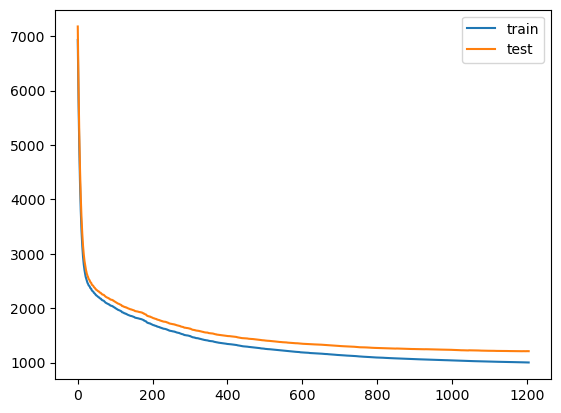

In [27]:
eval_model = model.evals_result()
train_loss = eval_model['validation_0']['rmse']
test_loss = eval_model['validation_1']['rmse']

plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()

In [4]:
# Grafica ambos errores 


In [7]:
# Calibracion

### Feature importances 

In [29]:
importancias = model.feature_importances_

df_importancias = pd.DataFrame({
    'features': X_test.keys(),
    'importancias': importancias
})
df_importancias = df_importancias.sort_values('importancias', ascending=False)
df_importancias

,features,importancias
16,StoreType_b,0.160660
1,Promo,0.135625
6,Promo2,0.074714
20,Assortment_c,0.066604
8,Promo2SinceYear,0.058820
4,CompetitionOpenSinceMonth,0.051655
17,StoreType_c,0.050718
3,CompetitionDistance,0.047633
22,"PromoInterval_Mar,Jun,Sept,Dec",0.043528
5,CompetitionOpenSinceYear,0.042237


```
from sklearn.inspection import PartialDependenceDisplay

for feature in importancias.features:
    PartialDependenceDisplay.from_estimator(model, X_test, [feature])
    plt.show()
```

In [5]:
# Partial dependence plot 


# Feature importance

### Gain 
Gain es que tanto disminuye la función de perdida, en promedio al usar cada feature


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

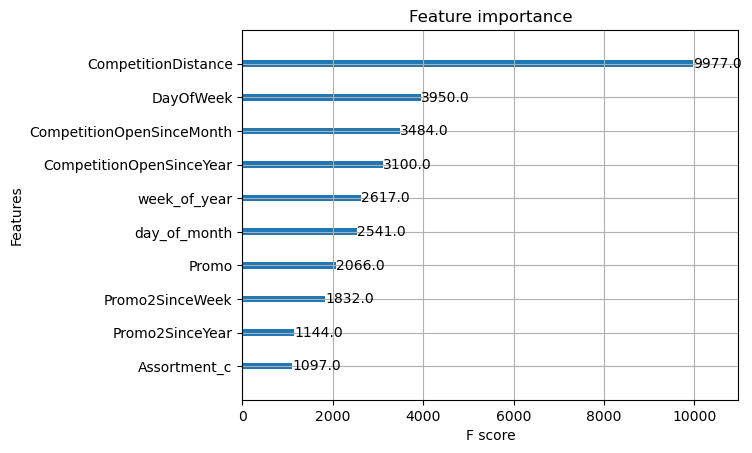

In [31]:
from xgboost import plot_importance

# Grafica la importancia, por importance_type y el max_num_features
plot_importance(model, max_num_features=10, importance_type='weight')


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

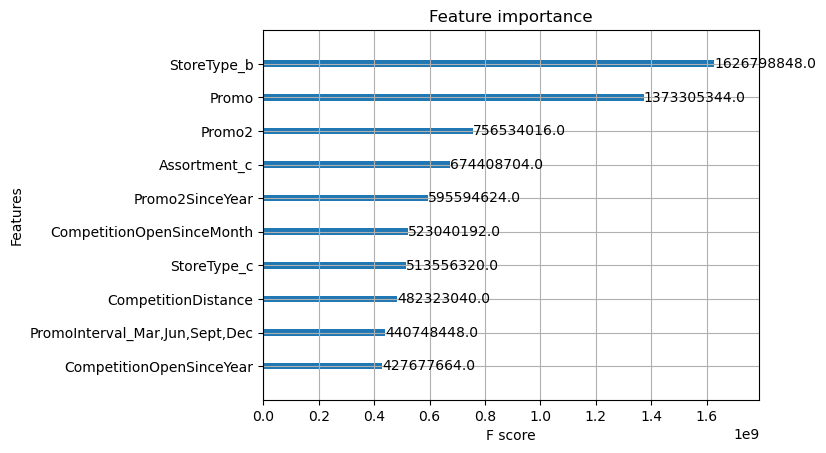

In [32]:
plot_importance(model, max_num_features=10, importance_type='gain')

### Weight
Weighr es el porcentaje de veces que se uso esa variable